# The Transiting Exoplanet Survey Sattelite (TESS)

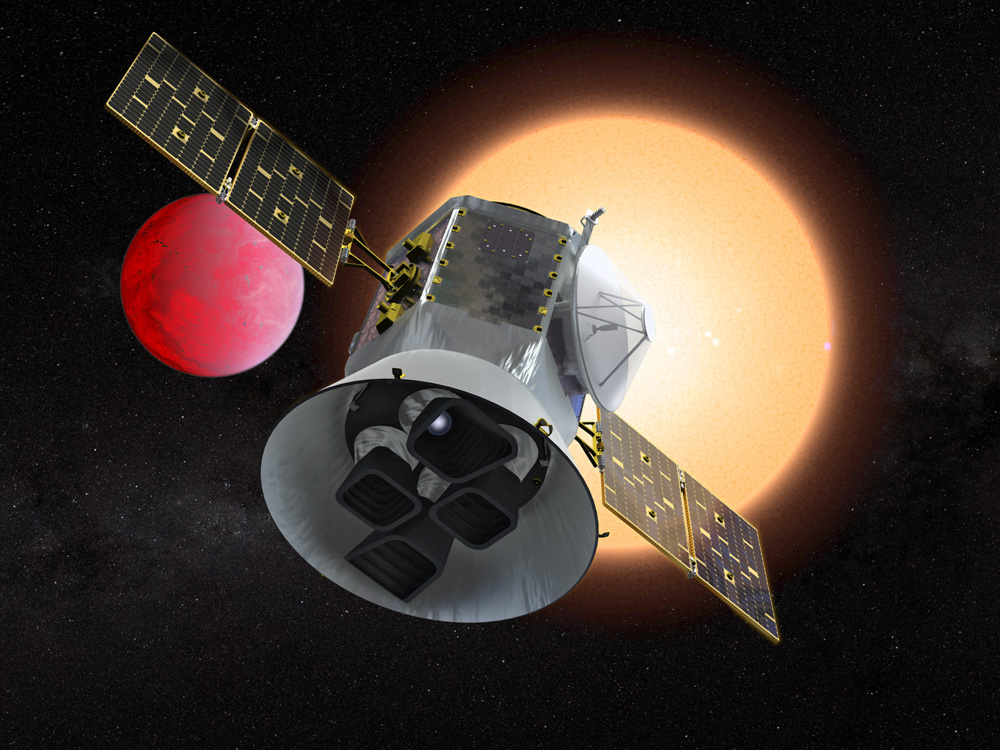 
*Image Credit: NASA*

The [Transiting Exoplanet Survey Satellite (TESS)](https://heasarc.gsfc.nasa.gov/docs/tess/objectives.html) is a NASA-sponsored Astrophysics Explorer-class mission that is performing a near all-sky survey to search for planets transiting nearby stars. The primary goal of TESS is to discover planets smaller than Neptune that transit stars bright enough to enable follow-up spectroscopic observations that can provide planet masses and atmospheric compositions. 

Now in its extended mission, TESS also carries out a wide range of astrophysics investigations as part of its regular observations - 
including stellar, extragalactic, and transient objects.  

## TESS-Vectors Introduction

The TESS-Vectors repository is an effort to take TESS mission engineering products and translate them into a more convenient, value-added form factor that is convenient for use by end-users.  

The information contained inside of these files is:

    - ExpTime: The final cadence binning (20s/120s/FFI)
    - Sector: The TESS observing Sector for the source data
    - Camera: The TESS camera for the source data
    - Cadence #: Cadence index from the source tpf
    - MidTime: The exposure midpoint in spacecraft time (i.e. tpf.time - tpf.timecorr)
    - Segment:We break the TESS Sector up into a number of #N segments, where each segment is seperated by >1hr of no TESS Observations
    - Quat_Start: The timestamp of the earliest quaternion used in the bin
    - Quat_Stop: The timestamp of the last quaternion used in the bin
    - Quat_MIN_FOM: The worst Figure of Merit from the source quaternions
    - Quat_MIN_NUM_GSUSED: The lowest number of guide stars used in the source quaternions
    - Quat_NBinned: The number of quaternions binned into this final result.
    - Quat[1-4]_Med: The Quaternion #[1-4] median value from the binned values 
    - Quat[1-4]_StdDev: The standard deviation of Quaternion #[1-4] binned values
    - Quat[1-4]_SigClip: The Sigma-Clipped Standard Deviation of Quaternion #[1-4] binned values
    - Earth_Distance: Distance to Earth in Earth Radii
    - Earth_Camera_Angle: Angle of Earth from Camera Boresight in Degrees
    - Earth_Camera_Azimuth: Azimuth of Earth around Camera Boresight in Degrees
    - Moon_Distance: Distance to Moon in Earth Radii
    - Moon_Camera_Angle: Angle of Moon from Camera Boresight in Degrees
    - Moon_Camera_Azimuth: Azimuth of Moon around Camera Boresight in Degrees
    - Earth_Spacecraft_Angle: Angle of Earth from Spacecraft Boresight in Degrees											
    - Earth_Spacecraft_Azimuth: Azimuth of Earth around Spacecraft Boresight in Degrees												-   
    - Moon_Spacecraft_Angle: Angle of Moon from Sacecraft Boresight in Degrees																- Moon_Spacecraft_Azimuth: Azimuth of Moon around Spacecraft Boresight in Degrees
    - (FFI Cadences Only) FFIFile: The FFI file assosciated with this observing cadence 

The information contained in these files generally comes from quaternion (\*-quat.fits) and earth-moon information (\*-emi.fits) [engineering files](https://archive.stsci.edu/missions-and-data/tess/data-products.html#mod_eng) that have been reprocessed to present results at the same time-cadence/binning as end usser TPFs'/lightcurves.

There is one TESS-Vectors file for every Cadence(20-second/120-second/FFI) and Camera/Sector.  We have also created some diagnostic plots to help guide the understanding of TESS observations for a given sector.  

## TESS-Vectors Use
We envision there to be a variety of use cases for the data contained within these products, and demonstrate two of them below - using the TESS-Vectors information to model the TESS pointing jitter noise via quaternion data, and using the TESS Earth-Moon Information to select TESS observations with a low scattered-light background.  We don't believe this will be the full extent of the use of these products - if you find a cool use case for them let us know!  

If you have any questions, comments, or concerns regarding the use of these vectors, or have suggestions as to the improvement of these products, please contact the [TESS Science Support Center Helpdesk](https://heasarc.gsfc.nasa.gov/docs/tess/helpdesk.html) at tesshelp@bigbang.gsfc.nasa.gov

## TESS Jitter Noise-modelling using the Quaternion Vectors
TESS takes an exposure every 2-seconds.  These exposures are then co-added onboard the sattelite, due to memory and data transfer constraints, to the FFI exposure time for the full CCD and to 20s or 120s for targets awarded a high-cadence postage stamp.  These are then downlinked for final pipeline processing. 

TESS pointing varies slightly over time, and it is calculated after every 2-second exposure on sky using a reference catalog of stars.  An offset vector is then calculated to return the TESS pointing to its nominal location.  These vectors are called ***Quaternions***.  
***It might be nice to create an image demonstrating this***

The centroids of a pixel can calculated from the final science calibrated target pixel file.  However, this *measured* centroid is also subject to other effects not due solely due to TESS's pointing - this includes, but is not limited to:
 - variability from other objects on the CCD
 - movement from the object itself
 - centroid movement from binary rotation/etc
 - and more!

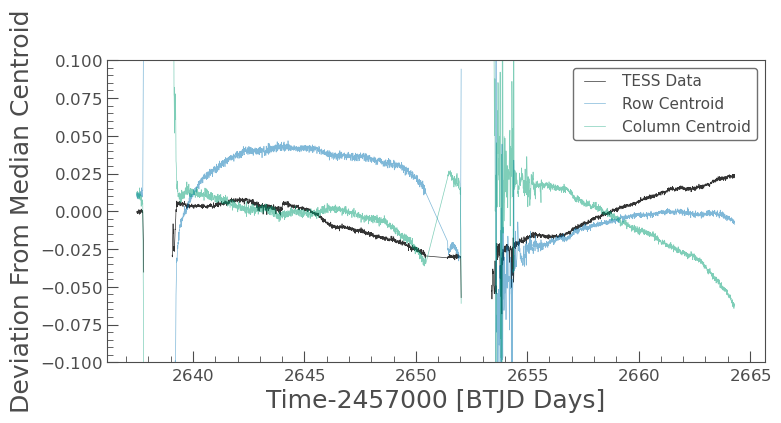 
*Image Credit https://github.com/tylerapritchard/TESSGI_Tut_NGC4151/blob/main/NGC4151.ipynb*  

The TESS-Vectors quaternions will allow us to build a noise-model from the TESS spacecraft pointing data itself to separate out noise jitter from the spacecraft itself and that caused by other, real astrophysical sources - allowing us to improve our meausrements

#### A note regarding TESS Quaternions
As discussed above, quaternions are calculated at a native time sampling of 2-seconds.  However, TESS Science observations are binned to either 20-seconds/120-seconds/200-seconds/10-minutes/30-minutes depending on the science product type.  

TESS Vectors therefore takes these native 2-second quaternions and re-bins them using the median quaternion value and reporting some summary statistics in the form of the standard deviation and sigma-clipped standard deviation.

For this example we will be using the quaternion standard deviation as *this is a measure of how stable the TESS pointing is for a given observation*


In [1]:
# Imports for creating this noise model
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.stats import sigma_clip, sigma_clipped_stats
from fbpca import pca

#### First, lets download a lightcurve - 
We're going to use Pi Men C in Sector 1 as a demo target for the rest of this notebook.  

Its worth noting that the quaternions are less stable in sector 1 compared to later sectors

In [2]:
rlcs = lk.search_lightcurve("Pi Men C", exptime=120, author="SPOC").download_all(quality_bitmask=1 | 2 | 4 | 8 | 32 | 128)

In [3]:
lcs = []
for lc in rlcs:
    lcs.append(lc.select_flux("sap_flux") + lc.sap_bkg)
lcs = lk.LightCurveCollection(lcs)

In [4]:
# Use one LC for now
TESSVectors_Loc='Products/Vectors/120_Cadence/'
lc = lcs[0]
df = pd.read_csv(f"{TESSVectors_Loc}/TessVectors_S001_C4_120.csv", comment="#")[
    lc.quality_mask
]

k = np.isfinite(np.asarray(lc.sap_bkg.value)) & np.isfinite(np.asarray(lc.sap_flux.value)) & np.isfinite(np.asarray(lc.sap_flux_err.value))
lc = lc[k]
df = df[k]

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

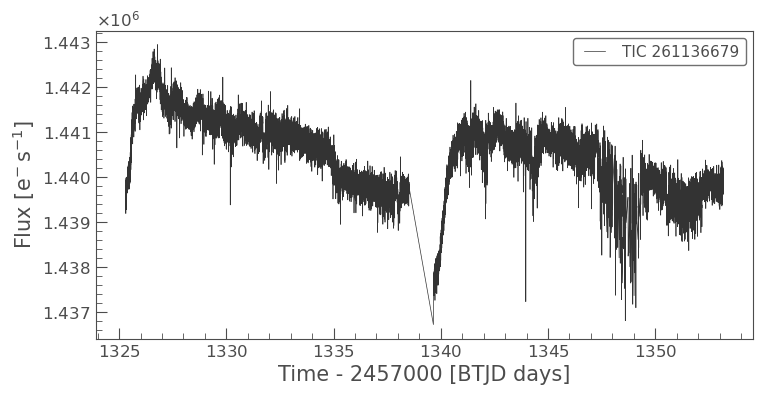

In [5]:
lc.plot(title="Pi Men C")

#### TESSVectors includes a "segment" values, which uses times when TESS was not observing to divide up sector observations into #N segments sepeared by >1hr of TESS non-observations.  
We'll use this to conveniently divide our TESS lightcurve into separate pieces since these different segments may have different noise properties.  

In [6]:
breakpoints = df.Segment.unique()
x = np.arange(len(lc))
masks = [df.Segment == seg for seg in df.Segment.unique()]

We are also going to median subtract and normalize each segment of the lightcurve

In [7]:
npoly = 3
t = lc.time.value
T = np.hstack([np.vstack([(((t - t[mask].mean())/(t[mask].max() - t[mask].min()))**idx) * mask for idx in np.arange(0, 5)]).T for mask in masks])

We're going to create two matrices based on quaternions that we will use to de-trend the data.  

 1) One is the median quaternion value over each expose.  This represents the median movement of the camera between each 2-second sub-exposure that gets co-added into the final TESS Exposure
 2) The second is the standard deviation of these individual exposure quaternion.  This represents the stability of this movement between exposures.
 3) **Should we add a quaternion SUM?**

We'll also create another matrix for detrending that is representing the target background as measured from the SPOC Simple Aperture Photometry background aperture



In [8]:
X1 = np.asarray(df[["Quat1_Med", "Quat2_Med", "Quat3_Med"]])
X2 = np.asarray(
    df[["Quat1_StdDev_SigClip", "Quat2_StdDev_SigClip", "Quat3_StdDev_SigClip"]]
)
X2 = np.hstack(
    [
        X2[:, idx:] * x if x.ndim == 2 else X2[:, idx:] * x[:, None]
        for idx, x in enumerate(X2.T)
    ]
)
X3 = np.vstack([np.asarray(lc.sap_bkg.value) ** idx for idx in np.arange(0, 2)]).T

# Time polynomial
X = np.hstack([X1, X2, X3[:, 1:]])
X = np.hstack([*[X * np.asarray(mask)[:, None] for mask in masks], T])


First, we'll create a background model using the background flux measurement

In [9]:
k = np.ones(len(lc), bool)
for count in range(3):
    bkg = X3.dot(np.linalg.solve(X3[k].T.dot(X3[k]), X3[k].T.dot(lc.flux.value[k])))
    k = ~np.asarray(sigma_clip(np.asarray(lc.flux.value) - bkg, 5).mask)

We can compage this with a "full" model that uses the background flux and the quaternion behavior

In [10]:
k = np.ones(len(lc), bool)
for count in range(3):
    sigma_w_inv = X[k].T.dot(X[k] / lc.flux_err[k].value[:, None] ** 2)
    B = X[k].T.dot(lc.flux[k].value / lc.flux_err[k].value ** 2)
    w = np.linalg.solve(sigma_w_inv, B)    
full_model = X.dot(w)

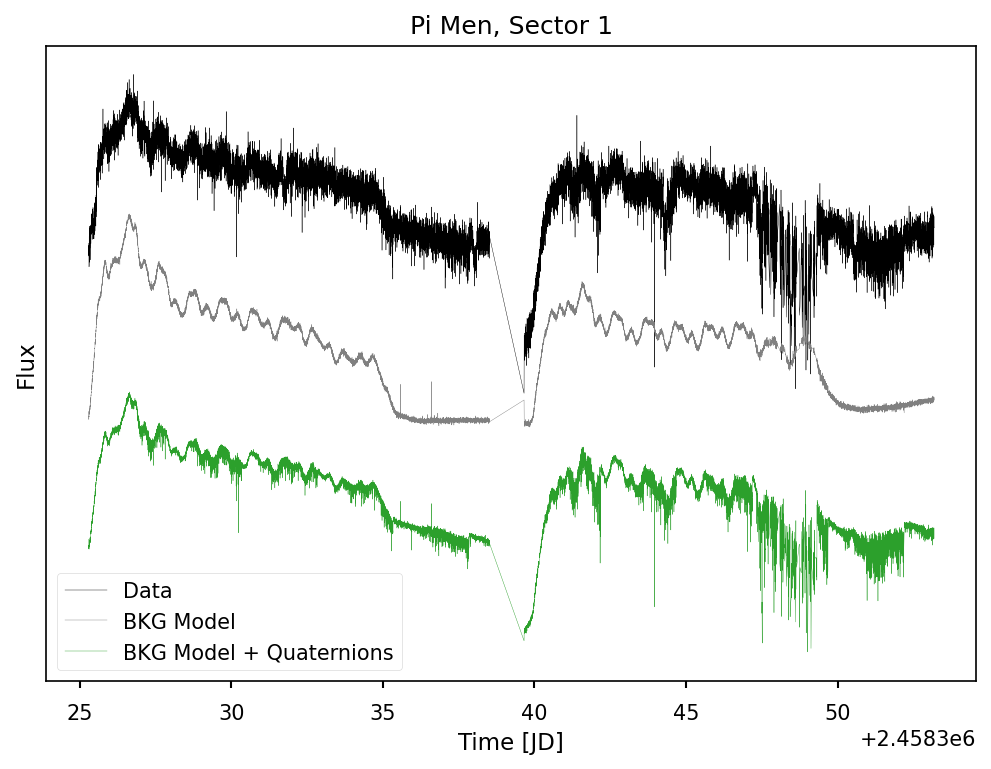

In [11]:
with plt.style.context("seaborn-v0_8-notebook"):
    fig, ax = plt.subplots(dpi=150)
    plt.plot(lc.time.jd, lc.flux, c="k", lw=0.2, label="Data")
    plt.plot(lc.time.jd, bkg * 0.998, c="grey", lw=0.2, label="BKG Model")
    plt.plot(
        lc.time.jd, full_model * 0.996, c="C2", lw=0.2, label="BKG Model + Quaternions"
    )
    ax.set(xlabel="Time [JD]", ylabel="Flux", yticks=[], title="Pi Men, Sector 1")
    plt.legend()

If we look at the residuals of the lightcurve - the background only model, we can see that we still have significant systematics in the remaining residuals

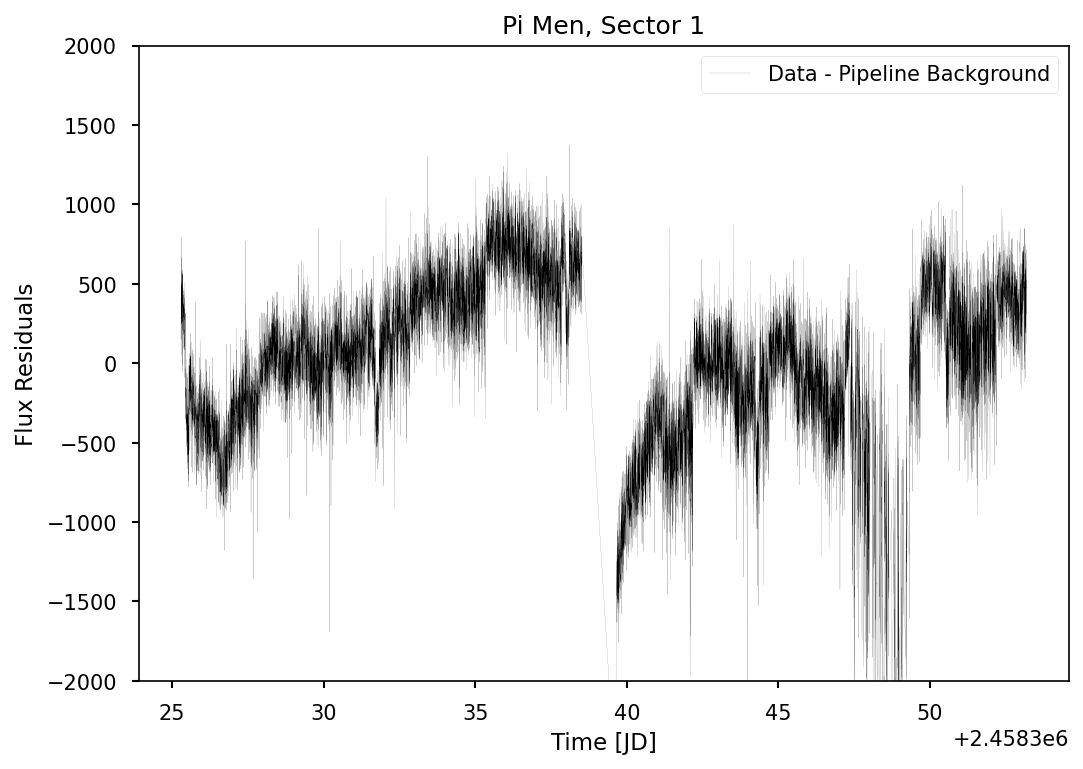

In [12]:
with plt.style.context("seaborn-v0_8-notebook"):
    fig, ax = plt.subplots(dpi=150)
    plt.plot(
        lc.time.jd,
        lc.flux.value - bkg,
        c="k",
        lw=0.05,
        label="Data - Pipeline Background",
    )
    ax.set(
        xlabel="Time [JD]",
        ylabel="Flux Residuals",
        title="Pi Men, Sector 1",
        ylim=(-2000, 2000),
    )
    plt.legend()

The residuals on our "full" model perform significantly better, where our systematic trends have been significantly reduced.  

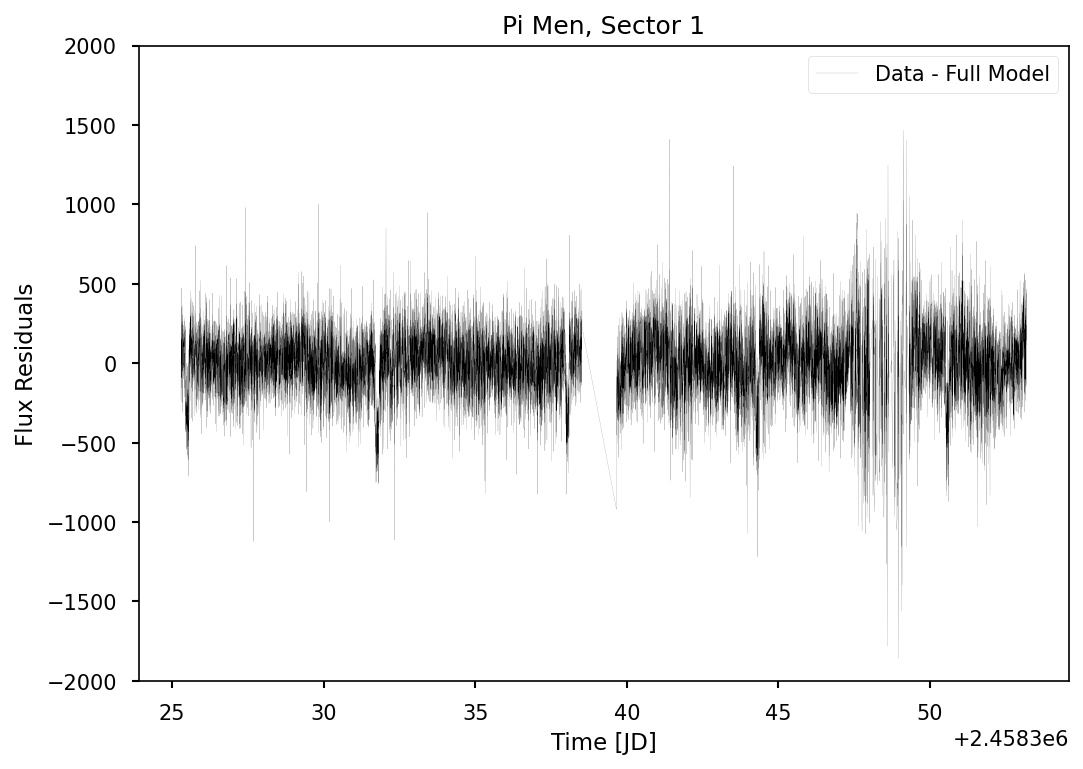

In [13]:
with plt.style.context("seaborn-v0_8-notebook"):
    fig, ax = plt.subplots(dpi=150)
    plt.plot(lc.time.jd, lc.flux.value - full_model, c="k", lw=0.05, label="Data - Full Model")
    ax.set(
        xlabel="Time [JD]",
        ylabel="Flux Residuals",
        title="Pi Men, Sector 1",
        ylim=(-2000, 2000),
    )
    plt.legend()

## Selection of TESS observations with a low scattered-light background 
TESS observes from a unique elliptical high Earth orbit (HEO) that provides an unobstructed view of its field to obtain continuous light curves and a more stable platform for precise photometry than the low Earth orbit. The nominal perigee and apogee of of the elliptical orbit are 17 Earth radii and 59 Earth radii, respectively. The exact orbital period varies between 12-15 days. The orbit places the spacecraft in a 2:1 resonance with the Moon.  

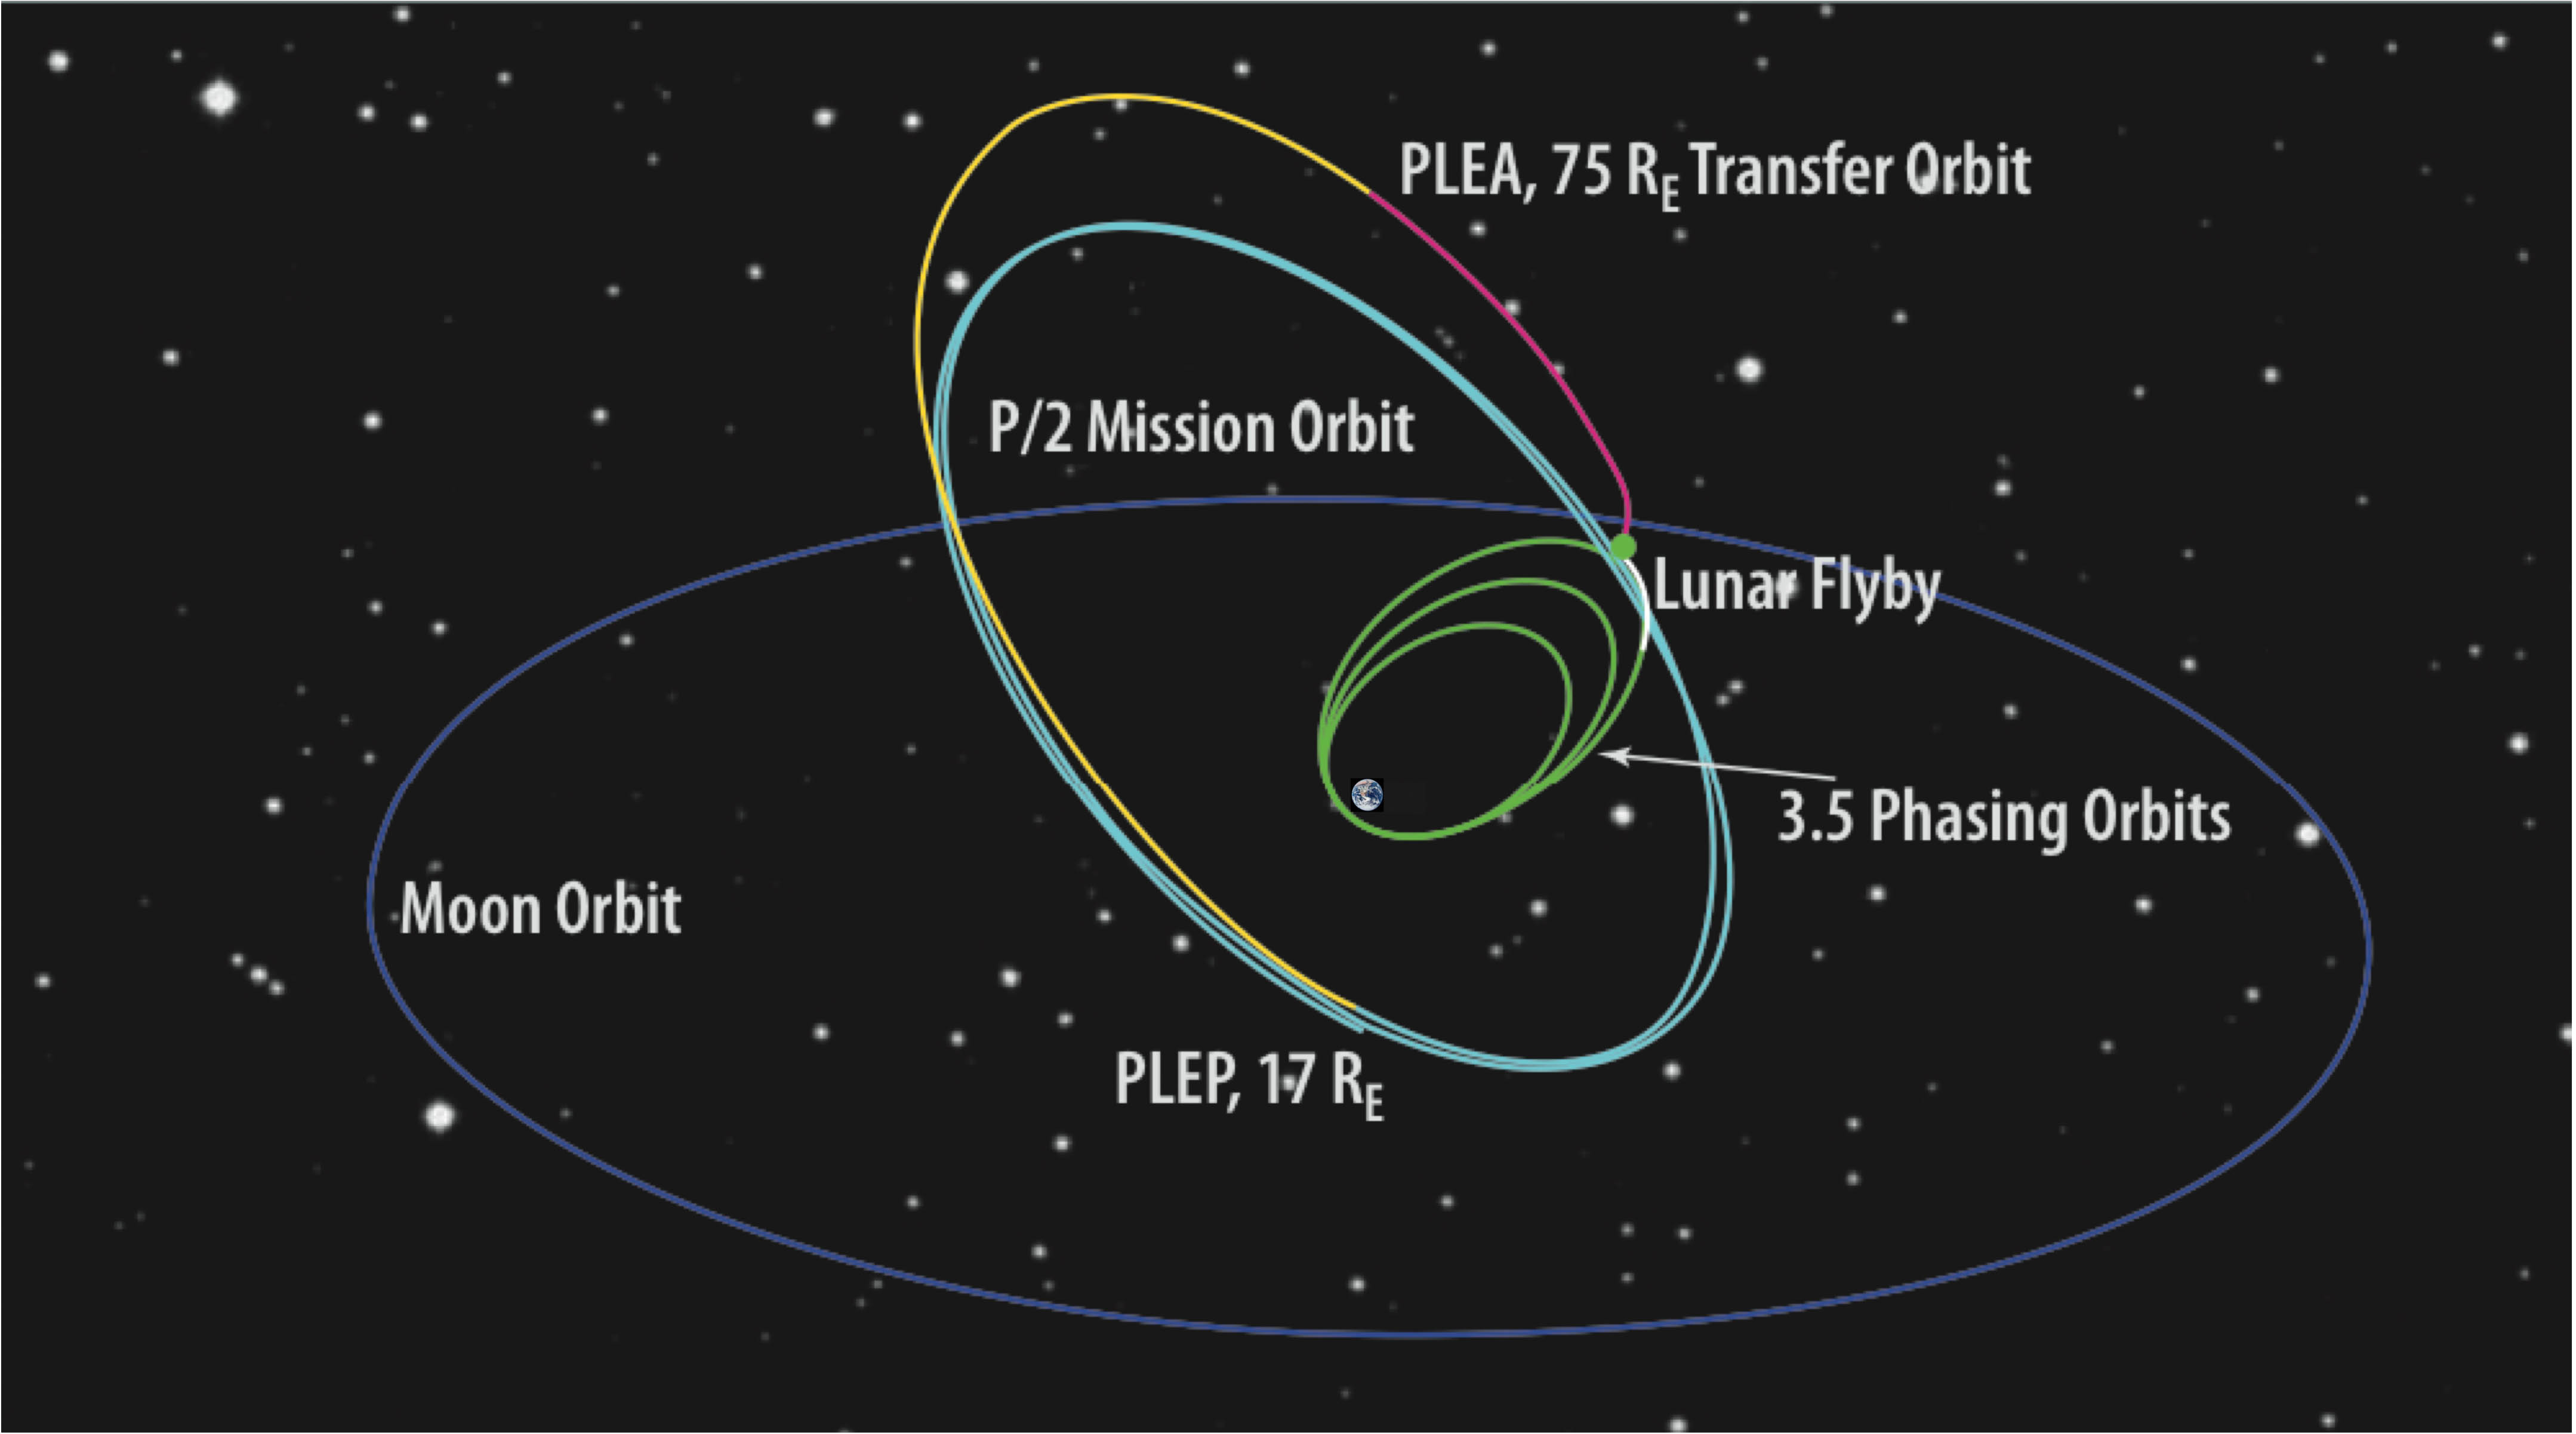
*Image Credit: Ricker et al. (2015)*

This elliptical, high Earth orbit means that the TESS scattered light sky background can vary drammattically based on where TESS is in relation to the Earth, Moon, and Sun.  You can watch a video of this happening [here](https://www.youtube.com/watch?v=SP4QSF9G6FA).   


The amplitude of the scattered light background can vary based on a variety of factors, but the two greatest are:
 1) The angle of the Earth/Moon with respect to the spacecraft sunshade
 2) The azimuthat angle of the Earth/Moon with respect to the Camera
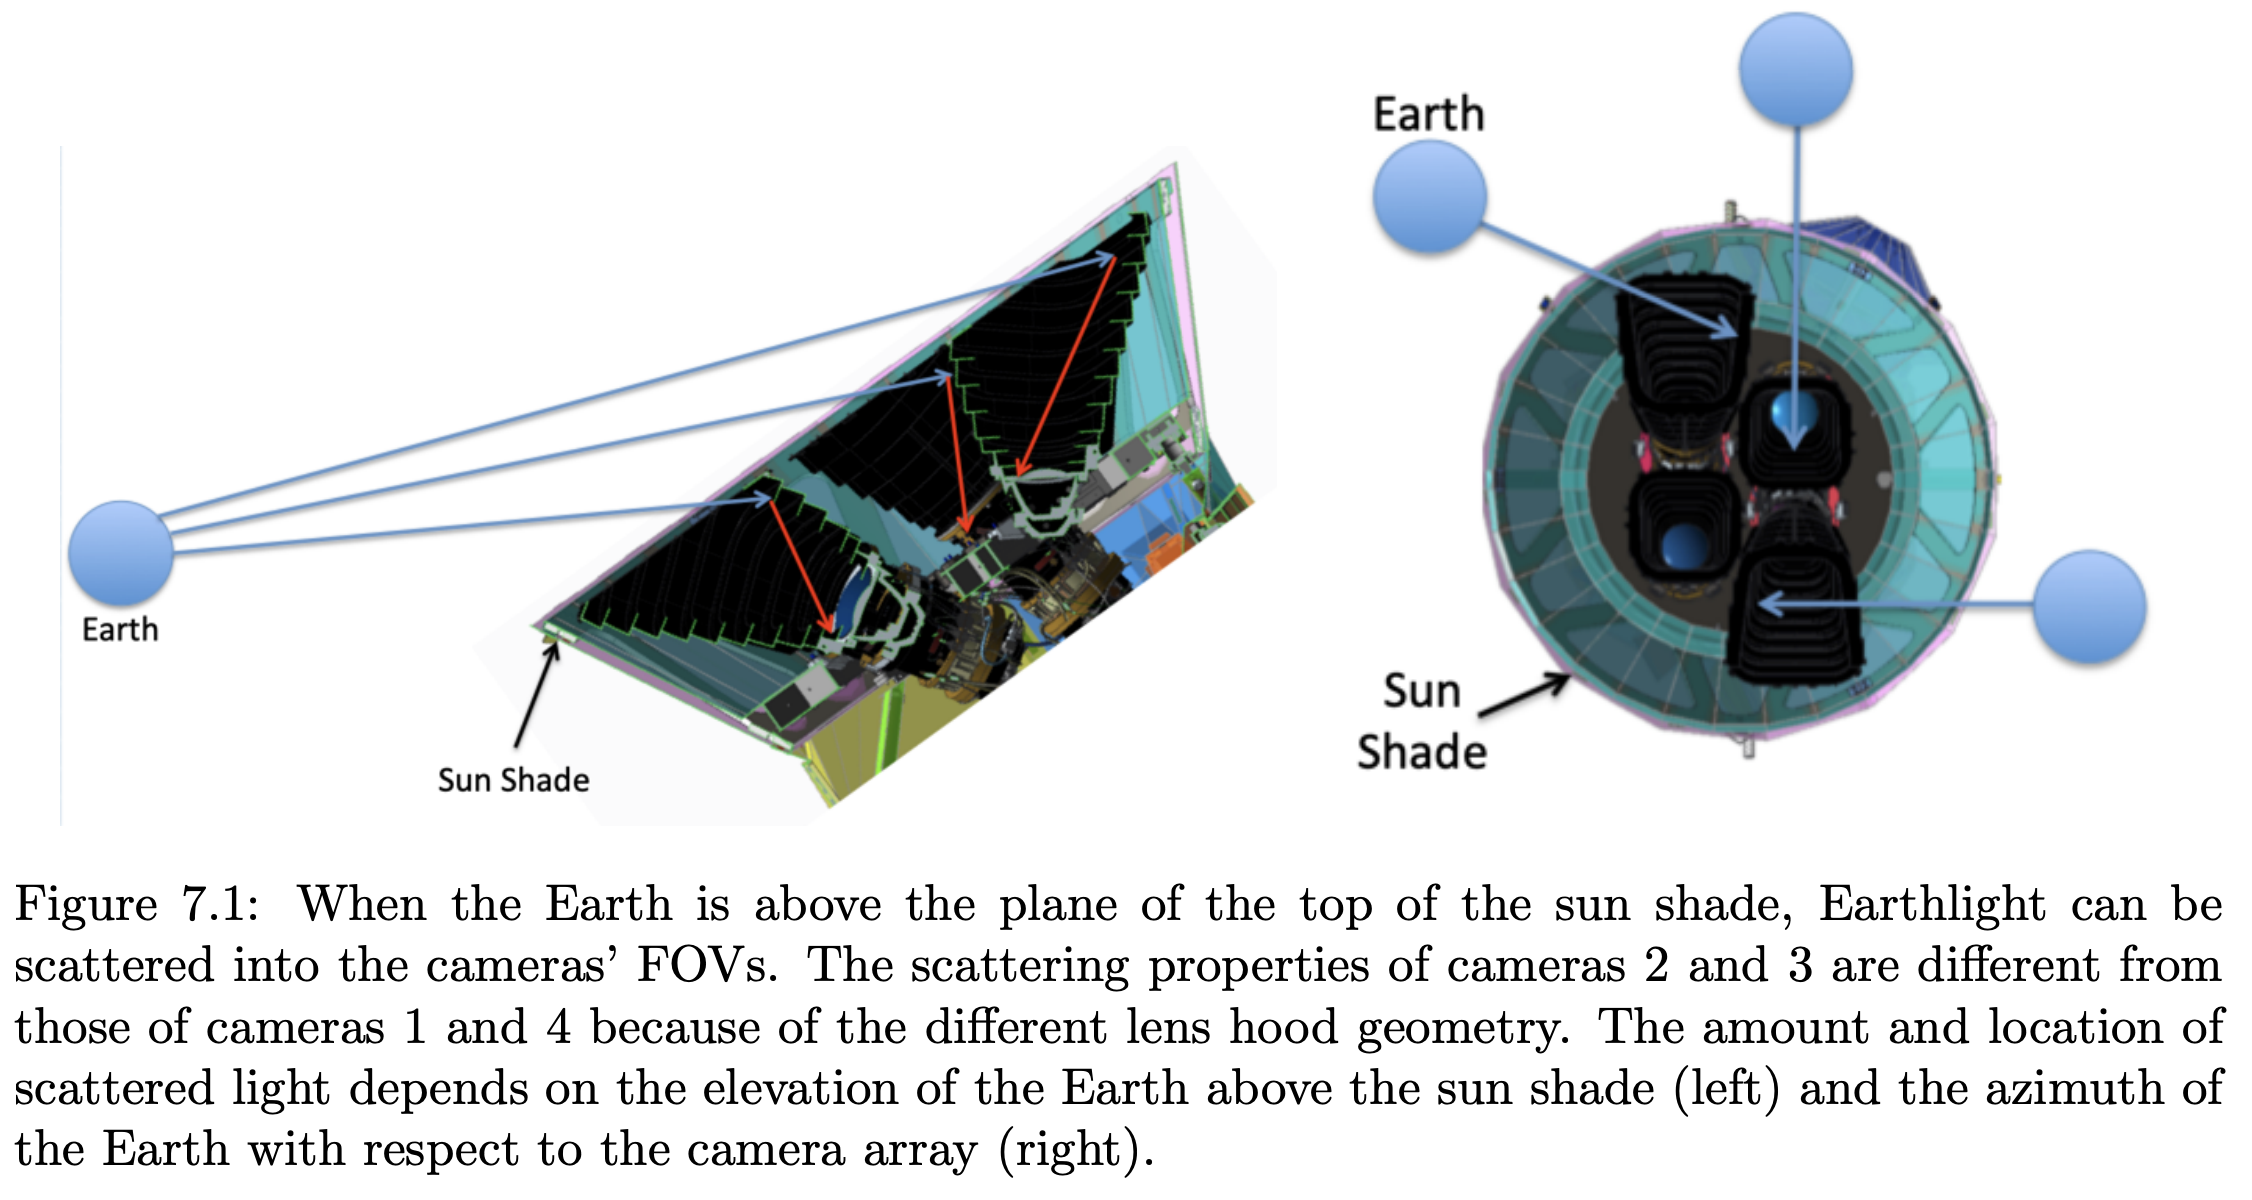
*Image & Caption Credit: [TESS Instrument Handbook, Vanderspek et al. 2018](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/active-missions/tess/_documents/TESS_Instrument_Handbook_v0.1.pdf)*

These two parameters are represented by the `(Earth/Moon)_Spacecraft_Angle` and the `(Earth/Moon)_Camera_Azimuth` columns in a TESSVector file, and these values are sourced from the `emi` files that can be found in the [TESS Engineering Files Bulk Downloads](https://archive.stsci.edu/missions/tess/engineering/).  Here we will demonstrate how to use the earth/moon angle relative to the spacecraft sunshade values to select for frames with a low sky background. (If the Earth/Moon are both significantly below the sunshade, their azimuthal orientation does not significantly contribute for scattered light).  


We will continue using Pi Men C from our example above, but use the TESSCut data and FFI cadence (observed at 30 minute cadence in Sector 1)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

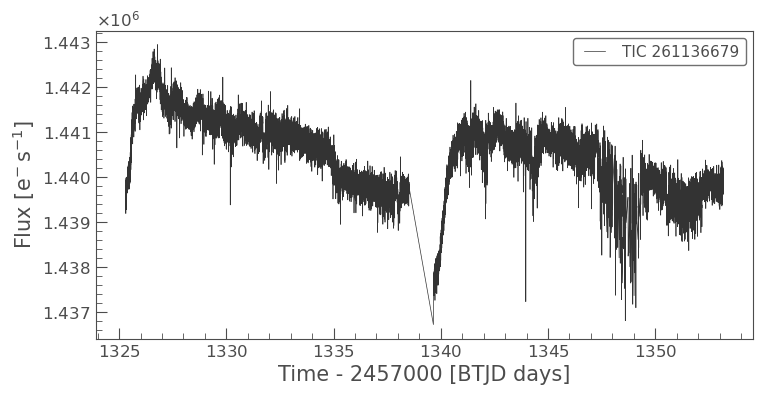

In [14]:
TESSVectors_Loc='Products/Vectors'
df = pd.read_csv(f"{TESSVectors_Loc}/FFI_Cadence/TessVectors_S001_C4_FFI.csv", comment="#")
lc = lcs[0]
lc.plot()

As discussed above, to select for FFI frames with a low scattered light background, we can use the Earth/Moon information to choose frames where the Earth & Moon are both significantly below the spacecraft sun shade (e.g. where Earth_Spacecraft_Angle & Moon_Spacecraft_Angle are significantly less than zero. Time when both the earth and moon are -2 to -5 degrees below the shade should be amongst the frames with the lowest background.  

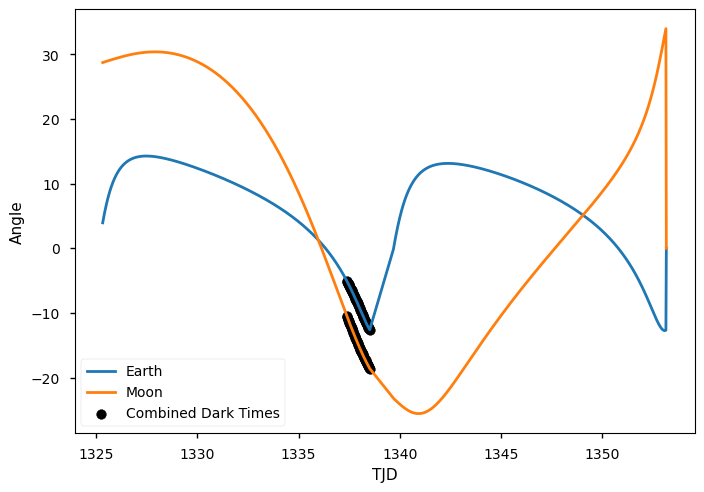

In [15]:
Earth_Cut = df.Earth_Spacecraft_Angle < -5
Moon_Cut = df.Moon_Spacecraft_Angle < -5
Combined_Cut = Earth_Cut & Moon_Cut

with plt.style.context("seaborn-v0_8-notebook"):
    plt.plot(df.MidTime, df.Earth_Spacecraft_Angle, linewidth=2, label = "Earth")
    plt.plot(df.MidTime, df.Moon_Spacecraft_Angle,linewidth=2, label = "Moon")

    plt.scatter(df.MidTime[Combined_Cut], df.Moon_Spacecraft_Angle[Combined_Cut], color='k', label = 'Combined Dark Times' )
    plt.scatter(df.MidTime[Combined_Cut], df.Earth_Spacecraft_Angle[Combined_Cut], color='k')

    plt.xlabel("TJD")
    plt.ylabel("Angle")
    plt.legend()
    plt.show()

We can check to see how well this cut does by using the median value of a pixel in a particular frame of a target pixel file as an estimate for the sky background, and then check to see what the values are of our selected frames during this time.  

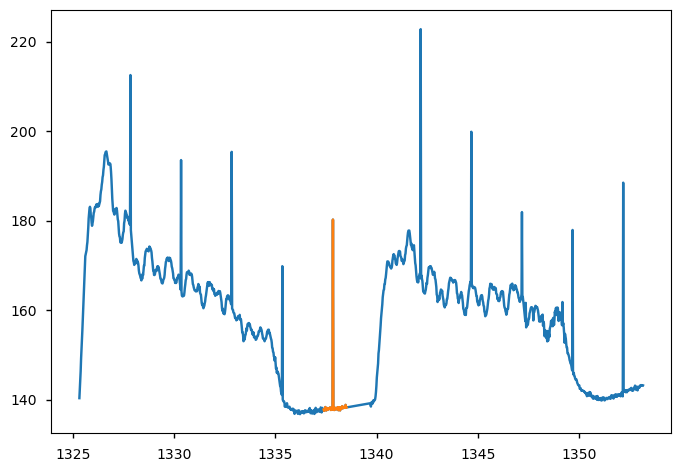

In [16]:
tpf = lk.search_tesscut("Pi Men C", sector=1).download(quality_bitmask='none', cutout_size=20)

with plt.style.context("seaborn-v0_8-notebook"):
    bkg = np.array([np.median(obs) for obs in np.array(tpf.flux)])
    plt.plot(tpf.time.value, bkg)
    plt.plot(tpf.time.value[Combined_Cut], bkg[Combined_Cut])

This has done fairly well at selecting for cadences with a low scattered light background.  IF we want to know what FFI's these frames correspond to, we can check the `FFIFile` column in the TESSVector file.  

In [17]:
ffi_name = df.FFIFile[Combined_Cut].values[0]
ffi_name

'tess2018218205942-s001-4-{ccd}-0120-s_ffic.fits'

These are the names of the specific calibrated FFI files that the chosen dark frames from TESSCut TPF have been cut out from.  To download them, we can construct a URI using the mast location of the file.  Looking at the [TESS Bulk Downloads](https://archive.stsci.edu/tess/bulk_downloads/bulk_downloads_ffi-tp-lc-dv.html) webpage on MAST, we can construct a URI to retrieve via wget:

In [18]:
# Calibrated and uncalibrated FFIs exist, to select the specific calibrated FFI we append a `c.fits` to the FFIFile Column.  
MAST_URI=f"https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/{ffi_name}c.fits"
MAST_URI

'https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018218205942-s001-4-{ccd}-0120-s_ffic.fitsc.fits'

### Selecting the FFI a high-cadence TPF frame can be found in

Using TESSVecrtors, we can also determine which FFI files are assosciated with a particular frame from a high-cadence TPF file.  For example, say we had a 120 second cadence TPF and we wanted to see which FFI contained data that includes a specific high-cadence TPF. 

For example, lets say we had a 120s cadence TPF and we wanted to grab the first FFI that contains the low scattered background above to use as a sky model.  

In [19]:
# First - set the stage - lets get the 120s cadence TESSVectors file
fast_cadence = pd.read_csv(f"{TESSVectors_Loc}/120_Cadence/TessVectors_S001_C4_120.csv", comment="#")

# Next, lets select our dark frames as described above
Earth_Cut = fast_cadence.Earth_Spacecraft_Angle < -5
Moon_Cut = fast_cadence.Moon_Spacecraft_Angle < -5
Combined_Cut = Earth_Cut & Moon_Cut

# Finaly, select the midtime of the first dark frame:
First_Dark_MidTime = fast_cadence[Combined_Cut].iloc[0].MidTime
First_Dark_MidTime

1337.370729227238

In [20]:
# Load up the FFI TESSVector
FFI_cadence = pd.read_csv(f"{TESSVectors_Loc}/FFI_Cadence/TessVectors_S001_C4_FFI.csv", comment="#")

# Find the FFI with the closest middle exposure time
Closest_Midtime_ind = np.argmin(First_Dark_MidTime - FFI_cadence.MidTime)
Closest_Midtime_ind

# Use this index to get the FFI file assosciated with the index and the high-cadence TPF frame above:
ffi_name = FFI_cadence.iloc[Closest_Midtime_ind].FFIFile
ffi_name

'tess2018234152941-s001-4-{ccd}-0120-s_ffic.fits'

TESS has 4 Cameras, and each Camera has 4 CCD's.  TESSVectors are calculated on a per camera basis, but FFI files are delivered on a per CCD basis.  to chose the file we want we should specify a campera. from the TPF above in this case.  

In [21]:
ffi_name = ffi_name.split('{')[0]+str(tpf.camera)+ffi_name.split('}')[1]
ffi_name

'tess2018234152941-s001-4-4-0120-s_ffic.fits'

In [22]:
# Calibrated and uncalibrated FFIs exist, to select the specific calibrated FFI we append a `c.fits` to the FFIFile Column.  
MAST_URI=f"https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/{ffi_name}"
MAST_URI

'https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018234152941-s001-4-4-0120-s_ffic.fits'

## Reconstructing the movement of the Earth/Moon around a TESS Camera

While the Earth/Moon Angles relative to the spacecraft sunshade are useful to select specific dark frames, more complicated scene modelling of TESS's background scattered light would likely need the positions of the earth & moon with respect to the camera position at all times throughout the orbit.

To visualise what this might look like, we can use the Earth/Moon Camera Angle/Azimuth and Earth/Moon Distance columns in a TESSVectors file to reconstruct the position of the Earth/Moon with respect to the Camera Boresight

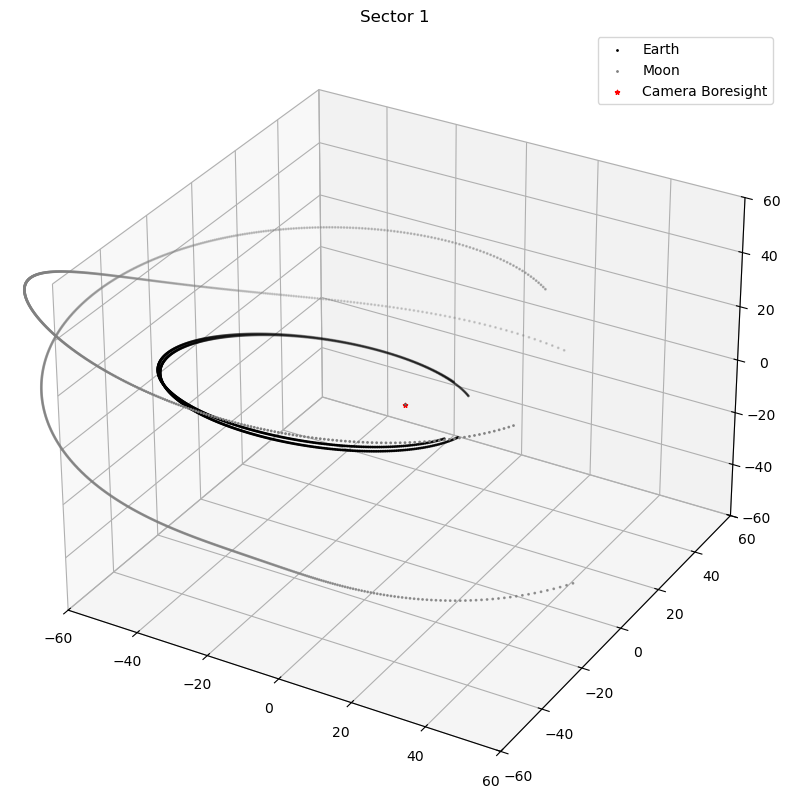

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1, projection='3d')

for body, color in zip(['Earth', 'Moon'], ['black', 'grey']):
    THETA = np.deg2rad(np.asarray(df[f"{body}_Spacecraft_Azimuth"])) 
    PHI = np.deg2rad(np.asarray(90 - df[f"{body}_Spacecraft_Angle"]))
    R = np.asarray(df[f"{body}_Distance"])

    X = R * np.sin(PHI) * np.cos(THETA)
    Y = R * np.sin(PHI) * np.sin(THETA)
    Z = R * np.cos(PHI)
    ax.scatter(X, Y, Z, c=color, s=1, label=body)

ax.scatter(0, 0, 0, c='red', s=10, marker='*', label='Camera Boresight')
ax.legend()
ax.set(xlim=(-60, 60), ylim=(-60, 60), zlim=(-60, 60), title='Sector 1')
plt.show()

Each sector of TESS data comprises two orbits of the TESS sattelite, which can be seen above via the two different orbital loops.  The gaps in the orbits represent gaps where TESS was not taking data (as TESSVectors are derived from TESS observations housekeeping/engineering data), and correspong do the gaps in the lightcurve of the object above.  These gaps occur when TESS is nearest to the Earth and downlinking observations.  

### Scene Modeling of scattered light background using earth/moon position information
These angular positions then can be fed into data-driven detrending methods for background modelling & calibration, or used to help construct position-dependant scene models of CCD backgrounds.  